# Lecture 2: the phase kickback trick

<center><img src="../figures/qibo_mascotte/qibo_boomerang.png" alt="drawing" width="400"/></center>
<center><strong>Fig. 2:</strong> Qibo experimenting the kickback [DALL-E].</center>

### Introduction

This is going to be a very short lecture, but still relevant to get familiar with one of the most simple and common tricks used in quantum computing: the phase kickback.

Before introducing and implementing an example of phase kickback, we should also introduce some terminology.
We typically refer to the main qubits of a system as the **input register** of that system.

In some situations, we could also need some more qubits, which we call **ancillas**. The **ancilla** is typically an extra qubit of your system, which can be useful for many reasons.

<center><img src="../figures/ancillas.png" alt="drawing" width="600"/></center>

In a nutshell, the phase kickback is a process in which we apply a controlled operation on a target qubit using another qubit as control, but amazingly we get a modification only in the control qubit!

Let's start importing some useful objects.

#### A necessary premise

What we are going to see is one interesting way to apply an amplitude manipulation of the **input register** without actually apply any gate on it!

It is important to mention that this same effect could be obtained by directly applying some gate on the **input register**, but this example is still interesting and, moreover, it will be useful to understand more complex algorithms such as Grover.

### Phase kickback

Let's consider two qubits: a first one is used as control, while a second is the target. An important requirement to exploit the phase kickback is that the second qubit's state is an eigenvector of the operator we aim to apply.

#### Phase kickback implementation

1. we initialize a two qubit circuit;
2. we apply an Hadamard gate to the first qubit, which is the **input register**, which will be the control one, and a Pauli X to the second qubit. This step will prepare the system into the state $$ |\psi_1\rangle = \frac{|01\rangle + |11\rangle}{\sqrt{2}}; $$
3. if the state vector of the target qubit $|q_{\rm t}\rangle$ is an eigenvector of the chosen gate $G$, it satisfies $$ G|q_{\rm t}\rangle = \lambda_G\,|q_{\rm t}\rangle.$$
4. In our case we may consider the controlled version of a $G$ gate, which has $|1\rangle$ as eigenvector:  $$ |\psi_2\rangle = CG |\psi_1\rangle = \frac{|01\rangle + G|11\rangle}{\sqrt{2}} = 
\frac{|01\rangle + \lambda_{G}|11\rangle}{\sqrt{2}} = \frac{|0\rangle + \lambda_{G}|1\rangle}{\sqrt{2}} \times |1\rangle.$$

After step 4., the state of the control qubit has been changed, while the target one is untouched.

#### Implementation

In [1]:
# if you don't have already qibo, qibojit and qiboedu installed in your computer
# uncomment and execute the following lines 

# !pip install qibo
# !pip install qibojit
# !pip install git+https://github.com/qiboteam/qiboedu

In [2]:
# import qibo modules, plot_probabilities_from_state function
from qibo import Circuit, gates
import qibo

from qiboedu.scripts.plotscripts import plot_probabilities_from_state

In [3]:
# set backend
qibo.set_backend("qibojit")

[Qibo 0.2.6|INFO|2024-03-25 19:50:51]: Using qibojit (numba) backend on /CPU:0


In [4]:
# circuit preparation: hadamard and NOT gate on the ancilla
# draw the circuit and check the state
c = Circuit(2)
c.add(gates.X(1))

print(c())

(1+0j)|01>


We consider the $T$ gate, which has the state $|1\rangle$ as eigenvector with eigenvalue $\lambda_G \neq 0$.

In [5]:
# check T has |1> as eigenvec
c = Circuit(1)
c.add(gates.X(0))
c.add(gates.T(0))

print(c())

(0.70711+0.70711j)|1>


In [6]:
def execute_circuit(kickback=False):
    """Execute circuit with or without phase kickback."""
    c = Circuit(2)
    c.add(gates.X(1))
    c.add(gates.H(0))
    if kickback:
        c.add(gates.T(1).controlled_by(0))
    c.add(gates.H(0))
    c.add(gates.M(*range(2)))

    outcome = c(nshots=1000)
    return outcome 

(1+0j)|01>


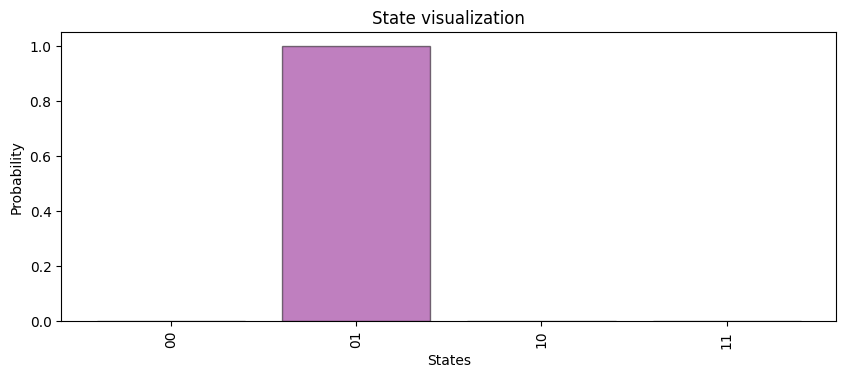

In [7]:
# collect outcome with kickback false
outcome = execute_circuit(kickback=False)

# print state
print(outcome)

# plot probabilities
plot_probabilities_from_state(outcome.state())

(0.85355+0.35355j)|01> + (0.14645-0.35355j)|11>


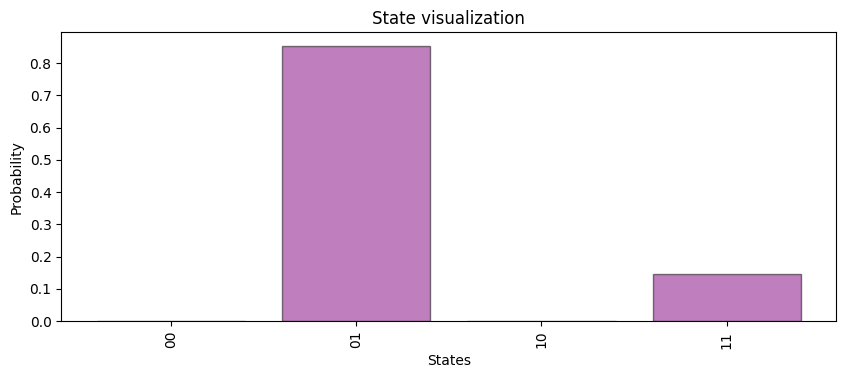

In [8]:
# collect outcome with kickback true
outcome = execute_circuit(kickback=True)

# print state
print(outcome)

# plot probabilities
plot_probabilities_from_state(outcome.state())

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> can you find a quantum gate $CG$ which applies a larger kickback effect then the $CT$ ? In other words, can you replace $CT$ in the previous circuit with a gate which reduces the $|01\rangle$ amplitude increasing the one of $|11\rangle$ ?
</div>

#### What happens if we repeat the phase kickback many times?

We now add the possibility to repeat the circuit architecture many times, in order to see what happens if we recursively manipulate the amplitude of the input register.

In [9]:
# adding recursion using the `ntimes` argument
def execute_circuit(kickback=False, ntimes=1):
    """Execute circuit with or without phase kickback."""
    c = Circuit(2)
    c.add(gates.X(1))
    for i in range(ntimes):
        c.add(gates.H(0))
        if kickback:
            c.add(gates.T(1).controlled_by(0))
        c.add(gates.H(0))
    c.add(gates.M(*range(2)))

    outcome = c(nshots=1000)
    return outcome 

(0.14645+0.35355j)|01> + (0.85355-0.35355j)|11>


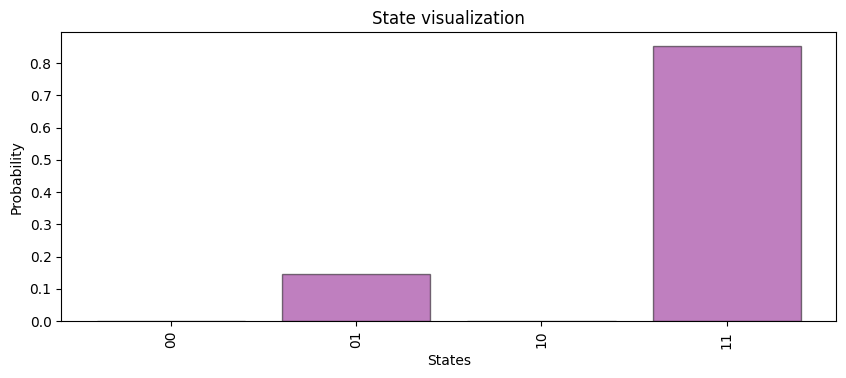

In [11]:
# collect outcome with kickback true
outcome = execute_circuit(kickback=True, ntimes=3)

# print state
print(outcome)

# plot probabilities
plot_probabilities_from_state(outcome.state())